## Comparison with iFS431

In [1]:
from reframed import pFBA, Environment, FVA, FBA, load_cbmodel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.gridspec import GridSpec

### Load data

In [2]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

env_cellb = Environment.from_compounds(media['DM_cellobiose'], max_uptake=1000)
env_cellb['R_EX_h2o_e'] = (-1000,1000)




### Dynamic FBA simulation

In [3]:
import reframed

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../functions/")

In [5]:
import dfba_ode

import kinetic_law_specific
import reframed
from reframed import Environment

from collections import OrderedDict
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
ethanol = pd.read_csv("../input/Desvaux2001_batch_data/ethanol_mmol.csv").drop(1).reset_index(drop=True)
acetate = pd.read_csv("../input/Desvaux2001_batch_data/acetate_mmol.csv").drop(1).reset_index(drop=True)
lactate = pd.read_csv("../input/Desvaux2001_batch_data/lactate_mmol.csv")


In [8]:
avg_etoh = ethanol[" y"].sum()/ethanol[" y"].shape[0]

avg_ac = acetate[" y"].sum()/acetate[" y"].shape[0]

avg_lac = lactate[" y"].sum()/lactate[" y"].shape[0]

In [9]:
model = reframed.load_cbmodel("../models/RcH10_final.xml")
model.reactions.R_EX_gal_e.ub=0
model.reactions.R_EX_rib__D_e.ub=0
model.add_ratio_constraint("R_EX_h2_e","R_EX_cellb_e",-4)
model.add_ratio_constraint("R_EX_ac_e","R_EX_etoh_e",round(avg_ac/avg_etoh,2)) # The closest ethanol and acetate are to each other https://www.microbiologyresearch.org/content/journal/micro/10.1099/00221287-147-6-1461
model.add_ratio_constraint("R_EX_ac_e","R_EX_lac__L_e",round(avg_ac/avg_lac,2)) # The closest ethanol and acetate are to each other https://www.microbiologyresearch.org/content/journal/micro/10.1099/00221287-147-6-1461

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

env_cellb = Environment.from_compounds(media['DM_cellobiose'], max_uptake=1000)
env_cellb['R_EX_h2o_e'] = (-1000,1000)
env_cellb.apply(model,warning=False)

env = env_cellb.copy()


C = OrderedDict()

C["R_EX_cellulose_e"] = 38.53897
C["R_EX_cellb_e"] = 0
C["R_EX_glc__D_e"] = 0

C["R_EX_ac_e"] = 0
C["R_EX_lac__L_e"] = 0
C["R_EX_etoh_e"] = 0
C["R_EX_pyr_e"] = 0
C["R_EX_h2_e"] = 0
C["R_EX_co2_e"] = 0
C["R_Growth"] = 0.02

from dfba_ode import glucose_kinetics,cellobiose_kinetics,cellulase_kinetics,KineticLaw

kinetic_laws = {}
kinetic_laws["R_EX_glc__D_e"] = KineticLaw("R_EX_glc__D_e",kinetic_law_func=glucose_kinetics,vmax=6.01,Km=0.2)
kinetic_laws["R_EX_cellb_e"] = KineticLaw("R_EX_cellb_e",kinetic_law_func=cellobiose_kinetics,vmax=5.01,Km=0.2)
kinetic_laws["R_EX_cellulose_e"] = KineticLaw(met="R_EX_cellulose_e",kinetic_law_func=cellulase_kinetics,vmax=2.9,Km=4.4,Ki=11)

external_rxns_fluxes =  {"R_EX_cellulose_e":dfba_ode.cellulase_flux}

In [10]:
ts = np.linspace(0, 150, 1000)  # Desired integration resolution and interval
y0 = np.array(list(C.values()))

with tqdm() as pbar:
    
    dynamic_system = dfba_ode.flux_predictions
    dynamic_system.pbar = pbar
    
    
    sol = solve_ivp(
        fun=dynamic_system,
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-4,
        atol=1e-4,
        method='RK23',
        args=(C.keys(),
        model,
        kinetic_laws,
        env,"R_Growth",external_rxns_fluxes)
    )

t = 150.000: : 6884it [02:15, 50.87it/s]


In [11]:
names = []
for key in C.keys():
    if key!="R_EX_cellulose_e" and key!="R_Growth":
        met = model.reactions[key].get_substrates()[0]
        met_name = model.metabolites[met].name
    elif key=="R_EX_cellulose_e":
        met_name = "Cellulose (hexose eq.)"
    elif key=="R_Growth":
        met_name = "Biomass"
    names.append(met_name)
    

C_time_series = dict(zip(names,sol.y))

C_df = pd.DataFrame(C_time_series)
C_df.index = sol.t
molar_mass = 173.85  # Based on glucose equivalent (based on 0.35 cellobiose and 0.3 glucose)
C_df["Cellulose (hexose eq.)"] = C_df["Cellulose (hexose eq.)"]*molar_mass/1000 # [g]

In [12]:
cellulose_exp = pd.read_csv("../input/Desvaux2001_batch_data/cellulose_g.csv")
biomass_exp = pd.read_csv("../input/Desvaux2001_batch_data/biomass_mg.csv")
ethanol = pd.read_csv("../input/Desvaux2001_batch_data/ethanol_mmol.csv")
acetate = pd.read_csv("../input/Desvaux2001_batch_data/acetate_mmol.csv")
lactate = pd.read_csv("../input/Desvaux2001_batch_data/lactate_mmol.csv")

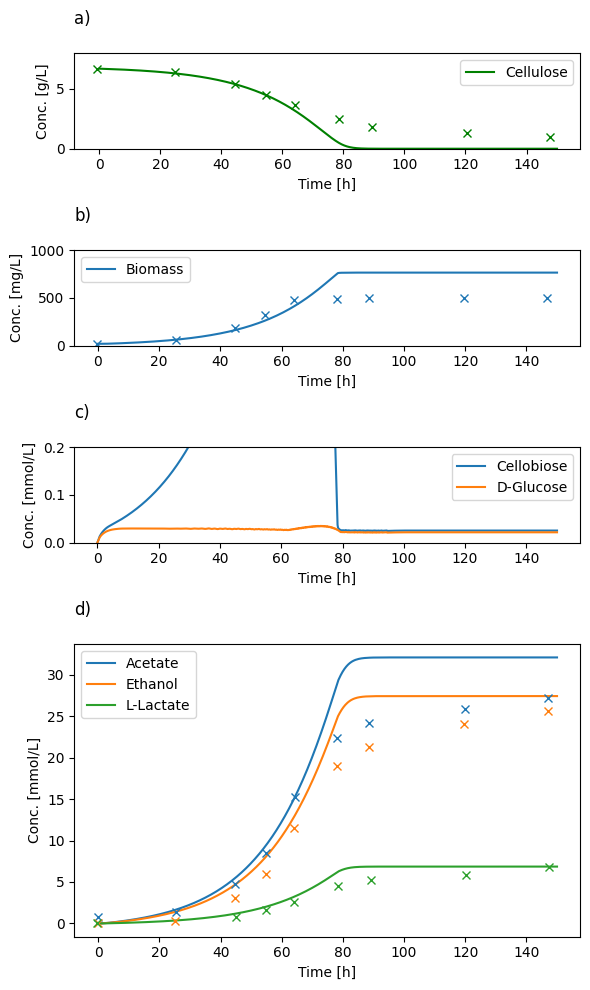

In [13]:
fig = plt.figure(figsize=(6,10))
gs = GridSpec(5,1,figure=fig)
ax1 = fig.add_subplot(gs[0:1, :])
ax2 = fig.add_subplot(gs[1:2,:])
ax3 = fig.add_subplot(gs[2:3,:])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax4 = fig.add_subplot(gs[3:,:])


C_df.loc[:,["Cellulose (hexose eq.)"]].plot(ax=ax1,xlabel="Time [h]",ylabel="Conc. [g/L]",color="green")
ax1.plot(cellulose_exp["x"].values,cellulose_exp[" y"].values,'x',color="green")
ax1.set_ylim([0,8])
ax1.legend(["Cellulose"])

pd.Series(index=C_df.index,data=np.array(C_df["Biomass"])*1000).plot(ax=ax2,xlabel="Time [h]",ylabel="Conc. [mg/L]")
ax2.plot(biomass_exp["x"].values,biomass_exp[" y"].values,'x',color="tab:blue")
ax2.set_ylim([0,1000])
ax2.legend(["Biomass"])

C_df.loc[:,["Cellobiose","D-Glucose"]].plot(ax=ax3,ylim=[0,0.2],xlabel="Time [h]",ylabel="Conc. [mmol/L]")

C_df.loc[:,["Acetate","Ethanol","L-Lactate"]].plot(ax=ax4,xlabel="Time [h]",ylabel="Conc. [mmol/L]")
ax4.plot(acetate["x"].values,acetate[" y"].values,'x',color="tab:blue")
ax4.plot(ethanol["x"].values,ethanol[" y"].values,'x',color="tab:orange")
ax4.plot(lactate["x"].values,lactate[" y"].values,'x',color="tab:green")

ax1.set_title("a)\n",loc="left")
ax2.set_title("b)\n",loc="left")
ax3.set_title("c)\n",loc="left")
ax4.set_title("d)\n",loc="left")

plt.tight_layout()
plt.savefig("../figures/batch_replication.png")